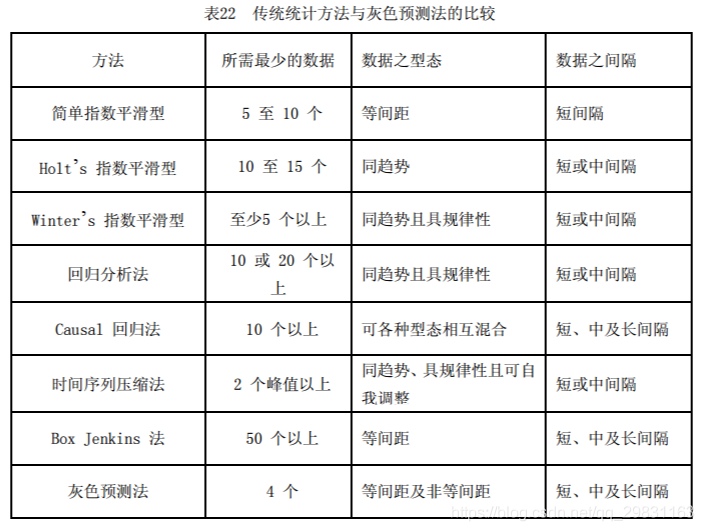

#### pros：
  
- 1. 需要的数据规模小
- 2. 精度高
- 3. 运算简便，易于检验

#### cons：

- 1. 只适合中短期预测
- 2. 只适合指数增长的预测
---

### 15.1.1 GM(1,1) 预测模型
> GM(1,1) 表示模型是 1 阶微分方程，且只含一个变量的灰色模型

1. 模型准备
   
   参考数据列 
   $$\boldsymbol x^{(0)}=\left(x^{(0)}(1), x^{(0)}(2), \cdots, x^{(0)}(n)\right)$$
   1 次累加生成序列 (1-AGO)
   $$
   \begin{align*}
   \boldsymbol x^{(1)}&=\left(x^{(1)}(1), x^{(1)}(2),\cdots, x^{(1)}(n)\right)\\
          &=\left(x^{(0)}(1), x^{(0)}(1)+x^{(0)}(2),\cdots, x^{(0)}(1)+\cdots+x^{(0)}(n)\right)
   \end{align*}
   $$
   $\boldsymbol x^{(1)}$ 的均值生成序列
   $$
   \boldsymbol z^{(1)}=\left(z^{(1)}(2), z^{(1)}(3), \cdots, z^{(1)}(n)\right)
   $$
   其中
   $$
   z^{(1)}(k)=0.5x^{(1)}(k)+0.5x^{(1)}(k-1),\quad k=2,3,\cdots,n
   $$
   记
   $$
   \boldsymbol B =
      \begin{bmatrix}
      -z^{(1)}(2) &1\\
      -z^{(1)}(3) &1\\
      \vdots      &\vdots\\
      -z^{(1)}(n) &1
      \end{bmatrix}\\
   \boldsymbol Y=\left[x^{(0)}(2), x^{(0)}(3), \cdots, x^{(0)}(n)\right]^{\rm T}
   $$
   $$
   \hat{\boldsymbol u}=\left[\hat a, \hat b\right]^{\rm T}=\left(\boldsymbol B^{\rm T}\boldsymbol B\right)^{-1}\boldsymbol B^{\rm T}\boldsymbol Y
   $$

2. 检验级比
   
   若序列的级比 $$\lambda (k)=\dfrac{x^{(0)}(k-1)}{x^{(0)}(k)},\quad k=2,3,\cdots,n$$ 都落在可容覆盖 $\Theta=\left({\rm e}^{-2/(n+1)},{\rm e}^{2/(n+1)}\right)$ 内，则该序列可以作为模型 GM(1,1) 的数据进行灰色预测；否则，需要对数列做平移变换 $$y^{(0)}(k)=x^{(0)}(k)+c,\quad k=1,2,\cdots,n$$

3. 建立模型

   预测值 $$\hat x^{(1)}(k+1)=\left(x^{(0)}(1)-\dfrac{\hat b}{\hat a}\right){\rm e}^{-\hat ak}+\dfrac{\hat b}{\hat a},\quad k=0,1,\cdots,n-1,\cdots$$
   
   则 $$\hat x^{(0)}(k+1)=\hat x^{(1)}(k+1)-\hat x^{(1)}(k),\quad k=1,2,\cdots,n-1,\cdots$$
4. 检验预测值
   
   (1) 相对误差检验
   $$\delta(k)=\dfrac{\left|x^{(0)}(k)-\hat x^{(0)}(k)\right|}{x^{(0)}(k)},\quad k=1,2,\cdots,n$$
   (2) 级比偏差值检验
   $$\rho(k)=\left|1-\left(\dfrac{1-0.5\hat a}{1+0.5\hat a}\right)\lambda(k)\right|$$

In [1]:
import numpy as np
import sympy as sp
sp.init_printing(use_latex=True)

x0 = np.array([71.1, 72.4, 72.4, 72.1, 71.4, 72.0, 71.6])
n = len(x0)
ratio = x0[:-1]/x0[1:]
bd_left, bd_right = np.exp(-2/(n+1)), np.exp(2/(n+1))
bd_left < ratio, ratio < bd_right   # 通过了级比检验

(array([ True,  True,  True,  True,  True,  True]),
 array([ True,  True,  True,  True,  True,  True]))

In [2]:
x1 = np.cumsum(x0)
z1 = 0.5*x1[1:] + 0.5*x1[:-1]
B = np.vstack([-z1, np.ones(n-1)]).T
Y = x0[1:]
ahat, bhat = np.linalg.inv(B.T @ B) @ B.T @ Y
ahat, bhat

In [3]:
k = sp.symbols('k', integer=True, nonneg=True)
x1_kp1 = (x0[0] - bhat/ahat)*sp.exp(-ahat*(k)) + bhat/ahat
ff_x1_kp1 = sp.lambdify(k, x1_kp1, 'numpy')

m = 10      # 所希望的预测序列的长度（含已知序列）
x1hat = np.zeros(m)
x1hat[0] = x1[0]
x1hat[1:] = ff_x1_kp1(np.arange(1, m))
x0hat = np.zeros(m)
x0hat[0] = x1hat[0]
for i in range(1, m):
    x0hat[i] = x1hat[i] - x1hat[i-1]
x0hat

array([71.1       , 72.40574144, 72.23623656, 72.0671285 , 71.89841633,
       71.73009912, 71.56217595, 71.39464589, 71.22750803, 71.06076145])

抽象成一个函数

In [4]:
def GM1_1(x0, m):
    """
    x0: 参考数据列
    m: 期望的预测序列长度
    RETURN: 
        if 通过级比检验 then (预测序列 x0hat，长度为 m, 参数列 u=[a, b])
        else 可容覆盖 (bd_left, bd_right)
    """
    n = len(x0)
    ratio = x0[:-1]/x0[1:]
    bd_left, bd_right = np.exp(-2/(n+1)), np.exp(2/(n+1))
    if not(all(bd_left < ratio) and all(ratio < bd_right)):   # 通过了级比检验
        print("级比检验未通过")
        return (bd_left, bd_right)
    x1 = np.cumsum(x0)
    z1 = 0.5*x1[1:] + 0.5*x1[:-1]
    B = np.vstack([-z1, np.ones(n-1)]).T
    Y = x0[1:]
    ahat, bhat = np.linalg.inv(B.T @ B) @ B.T @ Y

    k = sp.symbols('k', integer=True, nonneg=True)
    x1_kp1 = (x0[0] - bhat/ahat)*sp.exp(-ahat*(k)) + bhat/ahat
    ff_x1_kp1 = sp.lambdify(k, x1_kp1, 'numpy')
    x1hat = np.zeros(m)
    x1hat[0] = x1[0]
    x1hat[1:] = ff_x1_kp1(np.arange(1, m))
    x0hat = np.zeros(m)
    x0hat[0] = x1hat[0]
    for i in range(1, m):
        x0hat[i] = x1hat[i] - x1hat[i-1]
    return x0hat, (ahat, bhat)

In [5]:
x0hat, uhat = GM1_1(x0, 10)
x0hat

array([71.1       , 72.40574144, 72.23623656, 72.0671285 , 71.89841633,
       71.73009912, 71.56217595, 71.39464589, 71.22750803, 71.06076145])

误差检验

In [6]:
def rela_err(x0, x0hat):
    """
    计算相对误差
    x0: 原始数据列
    x0hat: 预测数据列
    RETURN: 与 x0 等长的相对误差列
    """
    diff = x0 - x0hat[:len(x0)]
    delta = np.abs(diff/x0)
    return delta

def ratio_err(x0, uhat):
    """
    计算级比误差
    x0: 原始数据列
    uhat: 预测的模型参数序列 [a, b]
    RETURN: 与 x0 等长的相对误差列
    """
    ratio = x0[:-1]/x0[1:]
    ahat = uhat[0]
    rho = np.abs(1 - (1 - 0.5*ahat)/(1 + 0.5*ahat)*ratio)
    return rho

In [7]:
rela_err(x0, x0hat), ratio_err(x0, uhat)

(array([0.00000000e+00, 7.93016634e-05, 2.26192594e-03, 4.55915376e-04,
        6.98062087e-03, 3.74862332e-03, 5.28268865e-04]),
 array([0.02025481, 0.00234104, 0.0018101 , 0.00743993, 0.01065487,
        0.00323247]))

给出建议的预测范围

In [8]:
def check_GM1_1(uhat):
    ahat = uhat[0]
    if np.abs(ahat)>2:
        print("没有意义")
    elif np.abs(ahat)<=2:
        print("有意义")
        if 0.3<-ahat<=0.5:
            print("适用于短期预测")
        elif 0.5<-ahat<=0.8:
            print("对于短期数据谨慎使用!")
        elif 0.8<-ahat<=1.0:
            print("应该对此模型进行修正!")
        elif -ahat>1.0:
            print("不宜使用GM(1,1)模型预测!")
        else:
            print("适用于中期和长期预测")

In [9]:
check_GM1_1(uhat)

有意义
适用于中期和长期预测


如果未通过级比检验，需要调用下面的函数

In [10]:
def translate(x0):
    """
    对未通过级比检验的原始序列 x0 作平移变换
    x0: 原始数据列
    RETURN: (平移后的数据列 y0, 偏移量 bias, 循环度 cnt)
        # 循环度衡量偏移的相对大小
    """
    n = len(x0)
    ratio = x0[:-1]/x0[1:]
    bd_left, bd_right = np.exp(-2/(n+1)), np.exp(2/(n+1))
    
    y0 = np.copy(x0)
    bias = x0[0]/10000
    cnt = 0
    while not(all(bd_left < ratio) and all(ratio < bd_right)):
        y0 += bias
        ratio = y0[:-1]/y0[1:]
        cnt += 1
    if (y0 - x0)[0]/x0[0] > 3:
        print("警告：不适宜使用灰色预测")
    return y0, (y0 - x0)[0], cnt

def inverse_translate(y0, bias):
    """
    平移的逆操作，返回原始数据
    """
    return y0 - bias

### 15.1.2 GM(2,1)、DGM 和 Verhulst 模型
GM(1,1) 只适用于具有较强指数规律的序列，只能描述单调的变化过程，对于非单调的摆动发展序列或有饱和的 S 形序列，可以考虑建立 GM(2,1)、DGM 和 Verhulst 模型

#### 1. GM(2,1) 模型
> GM(2,1) 表示模型是 2 阶微分方程，且只含一个变量的灰色模型

1. 模型准备
   
   参考数据列 
   $$\boldsymbol x^{(0)}=\left(x^{(0)}(1), x^{(0)}(2), \cdots, x^{(0)}(n)\right)$$
   1 次累加生成序列 (1-AGO)
   $$
   \begin{align*}
   \boldsymbol x^{(1)}&=\left(x^{(1)}(1), x^{(1)}(2),\cdots, x^{(1)}(n)\right)
   \end{align*}
   $$
   1 次累减生成序列 (1-IAGO)
   $$
   \boldsymbol \alpha^{(1)}\boldsymbol x^{(0)}=\left(\alpha^{(1)}x^{(0)}(2),\cdots,\alpha^{(1)}x^{(0)}(n)\right)
   $$
   其中
   $$
   \alpha^{(1)}x^{(0)}(k)=x^{(0)}(k) - x^{(0)}(k-1),\quad k=2,3,\cdots,n
   $$
   $\boldsymbol x^{(1)}$ 的均值生成序列
   $$
   \boldsymbol z^{(1)}=\left(z^{(1)}(2), z^{(1)}(3), \cdots, z^{(1)}(n)\right)
   $$
   记
   $$
   \boldsymbol B =
      \begin{bmatrix}
      -x^{(0)}(2) &-z^{(1)}(2) &1\\
      -x^{(0)}(3) &-z^{(1)}(3) &1\\
      \vdots      &\vdots      &\vdots\\
      -x^{(0)}(n) &-z^{(1)}(n) &1
      \end{bmatrix},\ 
   \boldsymbol Y=
   \begin{bmatrix}
   \alpha^{(1)}x^{(0)}(2)\\
   \alpha^{(1)}x^{(0)}(3)\\
   \vdots\\
   \alpha^{(1)}x^{(0)}(n)
   \end{bmatrix}
   $$
   $$
   \hat{\boldsymbol u}=\left[\hat a_1, \hat a_2, \hat b\right]^{\rm T}=\left(\boldsymbol B^{\rm T}\boldsymbol B\right)^{-1}\boldsymbol B^{\rm T}\boldsymbol Y,
   $$

2. 检验级比
   
   若序列的级比 $$\lambda (k)=\dfrac{x^{(0)}(k-1)}{x^{(0)}(k)},\quad k=2,3,\cdots,n$$ 都落在可容覆盖 $\Theta=\left({\rm e}^{-2/(n+1)},{\rm e}^{2/(n+1)}\right)$ 内，则该序列可以作为模型 GM(2,1) 的数据进行灰色预测；否则，需要对数列做平移变换 $$y^{(0)}(k)=x^{(0)}(k)+c,\quad k=1,2,\cdots,n$$
3. 建立模型

   GM(2,1) 模型
   $$
   \alpha^{(1)}x^{(0)}(k)+a_1x^{(0)}(k)+a_2z^{(1)}(k)=b
   $$
   白化方程
   $$
   \dfrac{{\rm d}^2x^{(1)}(t)}{{\rm d}t^2}+a_1\dfrac{{\rm d}x^{(1)}(t)}{{\rm d}t}+a_2x^{(1)}(t)=b
   $$
   借助边界条件 $x^{(1)}(1), x^{(1)}(n)$ 求解微分方程得到时间响应式 $\hat x^{(1)}(k+1)$，
   则经过 IAGO 还原，有 $$\hat x^{(0)}(k+1)=\hat x^{(1)}(k+1)-\hat x^{(1)}(k),\quad k=1,2,\cdots,n-1,\cdots$$
4. 检验预测值
   
   (1) 相对误差检验
   $$\delta(k)=\dfrac{\left|x^{(0)}(k)-\hat x^{(0)}(k)\right|}{x^{(0)}(k)},\quad k=1,2,\cdots,n$$
   (2) 级比偏差值检验
   $$\rho(k)=\left|1-\left(\dfrac{1-0.5\hat a}{1+0.5\hat a}\right)\lambda(k)\right|$$

In [11]:
x0 = np.array([41,49,61,78,96,104])  #原始序列
n = len(x0)
ratio = x0[:-1]/x0[1:]
bd_left, bd_right = np.exp(-2/(n+1)), np.exp(2/(n+1))
all(bd_left < ratio) and all(ratio < bd_right)  # 通过了级比检验

True

In [12]:
x1 = np.cumsum(x0)
ax0 = x0[1:] - x0[:-1]
z1 = 0.5*x1[1:] + 0.5*x1[:-1]
B = np.vstack([-x0[1:], -z1, np.ones(n-1)]).T
Y = ax0
a1hat, a2hat, bhat = np.linalg.inv(B.T @ B) @ B.T @ Y
a1hat, a2hat, bhat

In [13]:
x = sp.symbols('x', cls=sp.Function)
t = sp.symbols('t', real=True)
eq = sp.Eq(x(t).diff(t, 2) + a1hat*x(t).diff(t) + a2hat*x(t), bhat)
x1t = sp.dsolve(eq, ics={x(0): x1[0], x(n-1): x1[-1]}).args[1]
ff_x1_kp1 = sp.lambdify(t, x1t, 'numpy')

m = 8
x1hat = np.zeros(m)
x1hat[0] = x1[0]
x1hat[1:] = ff_x1_kp1(np.arange(1, m))
x0hat = np.zeros(m)
x0hat[0] = x1hat[0]
for i in range(1, m):
    x0hat[i] = x1hat[i] - x1hat[i-1]
x0hat

array([ 41.        ,  51.01481441,  63.14123779,  77.21114017,
        92.15478971, 104.47801792, 104.68156355,  68.68742438])

抽象成函数

In [14]:
def GM2_1(x0, m):
    """
    x0: 参考数据列
    m: 期望的预测序列长度
    RETURN: 
        if 通过级比检验 then (预测序列 x0hat，长度为 m, 参数列 u=[a1, a2, b])
        else 可容覆盖 (bd_left, bd_right)
    """
    n = len(x0)
    ratio = x0[:-1]/x0[1:]
    bd_left, bd_right = np.exp(-2/(n+1)), np.exp(2/(n+1))
    if not(all(bd_left < ratio) and all(ratio < bd_right)):   # 通过了级比检验
        print("级比检验未通过")
        return (bd_left, bd_right)

    x1 = np.cumsum(x0)
    ax0 = x0[1:] - x0[:-1]
    z1 = 0.5*x1[1:] + 0.5*x1[:-1]
    B = np.vstack([-x0[1:], -z1, np.ones(n-1)]).T
    Y = ax0
    a1hat, a2hat, bhat = np.linalg.inv(B.T @ B) @ B.T @ Y
    
    x = sp.symbols('x', cls=sp.Function)
    t = sp.symbols('t', real=True)
    eq = sp.Eq(x(t).diff(t, 2) + a1hat*x(t).diff(t) + a2hat*x(t), bhat)
    x1t = sp.dsolve(eq, ics={x(0): x1[0], x(n-1): x1[-1]}).args[1]
    ff_x1_kp1 = sp.lambdify(t, x1t, 'numpy')
    
    x1hat = np.zeros(m)
    x1hat[0] = x1[0]
    x1hat[1:] = ff_x1_kp1(np.arange(1, m))
    x0hat = np.zeros(m)
    x0hat[0] = x1hat[0]
    for i in range(1, m):
        x0hat[i] = x1hat[i] - x1hat[i-1]

    return x0hat, (a1hat, a2hat, bhat)

In [15]:
x0hat, uhat = GM2_1(x0, 8)
x0hat

array([ 41.        ,  51.01481441,  63.14123779,  77.21114017,
        92.15478971, 104.47801792, 104.68156355,  68.68742438])

In [16]:
rela_err(x0, x0hat), ratio_err(x0, uhat)

(array([0.        , 0.04111866, 0.03510226, 0.01011359, 0.04005427,
        0.00459633]),
 array([1.85011849, 1.73615933, 1.66385371, 1.76756932, 2.14422077]))

#### 2. DGM(2,1) 模型
1. 模型准备
   
   原始序列 $\boldsymbol x^{(0)}$，1-AGO 序列 $\boldsymbol x^{(1)}$，1-IAGO 序列 $\boldsymbol\alpha^{(1)}\boldsymbol x^{(0)}$
   $$
   \boldsymbol B =
      \begin{bmatrix}
      -x^{(0)}(2) &1\\
      -x^{(0)}(3) &1\\
      \vdots      &\vdots\\
      -x^{(0)}(n) &1
      \end{bmatrix},\ 
   \boldsymbol Y=
   \begin{bmatrix}
   \alpha^{(1)}x^{(0)}(2)\\
   \alpha^{(1)}x^{(0)}(3)\\
   \vdots\\
   \alpha^{(1)}x^{(0)}(n)
   \end{bmatrix}
   $$
   $$
   \hat{\boldsymbol u}=\left[\hat a, \hat b\right]^{\rm T}=\left(\boldsymbol B^{\rm T}\boldsymbol B\right)^{-1}\boldsymbol B^{\rm T}\boldsymbol Y,
   $$

2. 建立模型
   
   DGM(2,1) 模型
   $$
   \alpha^{(1)}x^{(0)}(k)+ax^{(0)}(k)=b
   $$
   白化方程
   $$
   \dfrac{{\rm d}^2x^{(1)}(t)}{{\rm d}t^2}+a\dfrac{{\rm d}x^{(1)}(t)}{{\rm d}t}=b
   $$
   白化方程的解（时间响应函数）
   $$
   \hat x^{(1)}(k+1)=\left(\dfrac{\hat b}{\hat a^2}-\dfrac{x^{(0)}(1)}{\hat a}\right){\rm e}^{-\hat ak}+\dfrac{\hat b}{\hat a}k+\dfrac{1+\hat a}{\hat a}x^{(0)}(1)-\dfrac{\hat b}{\hat a^2}
   $$
   从而
   $$\hat x^{(0)}(k+1)=\hat x^{(1)}(k+1)-\hat x^{(1)}(k)$$
> 级比检验和误差检验略去不表

In [17]:
x0 = np.array([2.874,3.278,3.39,3.679,3.77,3.8])  #原始序列
n = len(x0)
ratio = x0[:-1]/x0[1:]
bd_left, bd_right = np.exp(-2/(n+1)), np.exp(2/(n+1))
all(bd_left < ratio) and all(ratio < bd_right)  # 通过了级比检验

True

In [18]:
x1 = np.cumsum(x0)
ax0 = x0[1:] - x0[:-1]
B = np.vstack([-x0[1:], np.ones(n-1)]).T
Y = ax0
ahat, bhat = np.linalg.inv(B.T @ B) @ B.T @ Y
ahat, bhat

In [19]:
k = sp.symbols('k', integer=True, nonneg=True)
x1_kp1 = (bhat/ahat**2 - x0[0]/ahat)*sp.exp(-ahat*(k)) + (bhat/ahat)*k + \
    (1 + ahat)/ahat*x0[0] - bhat/ahat**2
ff_x1_kp1 = sp.lambdify(k, x1_kp1, 'numpy')

m = 6
x1hat = np.zeros(m)
x1hat[0] = x1[0]
x1hat[1:] = ff_x1_kp1(np.arange(1, m))
x0hat = np.zeros(m)
x0hat[0] = x1hat[0]
for i in range(1, m):
    x0hat[i] = x1hat[i] - x1hat[i-1]
x0hat

array([2.874     , 3.08600136, 3.40883478, 3.62010527, 3.75836611,
       3.84884755])

抽象为函数

In [20]:
def DGM2_1(x0, m):
    """
    x0: 参考数据列
    m: 期望的预测序列长度
    RETURN: 
        if 通过级比检验 then (预测序列 x0hat，长度为 m, 参数列 u=[a, b])
        else 可容覆盖 (bd_left, bd_right)
    """
    n = len(x0)
    ratio = x0[:-1]/x0[1:]
    bd_left, bd_right = np.exp(-2/(n+1)), np.exp(2/(n+1))
    if not(all(bd_left < ratio) and all(ratio < bd_right)):   # 通过了级比检验
        print("级比检验未通过")
        return (bd_left, bd_right)

    x1 = np.cumsum(x0)
    ax0 = x0[1:] - x0[:-1]
    B = np.vstack([-x0[1:], np.ones(n-1)]).T
    Y = ax0
    ahat, bhat = np.linalg.inv(B.T @ B) @ B.T @ Y

    k = sp.symbols('k', integer=True, nonneg=True)
    x1_kp1 = (bhat/ahat**2 - x0[0]/ahat)*sp.exp(-ahat*(k)) + (bhat/ahat)*k + \
        (1 + ahat)/ahat*x0[0] - bhat/ahat**2
    ff_x1_kp1 = sp.lambdify(k, x1_kp1, 'numpy')

    x1hat = np.zeros(m)
    x1hat[0] = x1[0]
    x1hat[1:] = ff_x1_kp1(np.arange(1, m))
    x0hat = np.zeros(m)
    x0hat[0] = x1hat[0]
    for i in range(1, m):
        x0hat[i] = x1hat[i] - x1hat[i-1]
    return x0hat, (ahat, bhat)

In [21]:
x0hat, uhat = DGM2_1(x0, 10)
x0hat

array([2.874     , 3.08600136, 3.40883478, 3.62010527, 3.75836611,
       3.84884755, 3.90806093, 3.94681169, 3.97217118, 3.98876708])

In [22]:
rela_err(x0, x0hat), ratio_err(x0, uhat)

(array([0.        , 0.05857189, 0.00555598, 0.01600835, 0.00308591,
        0.01285462]),
 array([0.42996349, 0.37131354, 0.40090628, 0.36552678, 0.354966  ]))

#### 3. 灰色 Verhulst 预测模型
Verhulst 模型主要用来描述具有饱和状态的过程，即 S 形过程，常用于人口预测、生物生长、繁殖预测及产品经济寿命预测等

1. 模型准备

   原始序列 $\boldsymbol x^{(0)}$，1-AGO 序列 $\boldsymbol x^{(1)}$，$\boldsymbol x^{(1)}$ 的均值生成序列 $\boldsymbol z^{(1)}$
   $$
   \boldsymbol B =
      \begin{bmatrix}
      -z^{(1)}(2) &\left(z^{(1)}(2)\right)^2\\
      -z^{(1)}(3) &\left(z^{(1)}(3)\right)^2\\
      \vdots      &\vdots                   \\
      -z^{(1)}(n) &\left(z^{(1)}(n)\right)^2
      \end{bmatrix},\ 
   \boldsymbol Y=
   \begin{bmatrix}
   x^{(0)}(2)\\
   x^{(0)}(3)\\
   \vdots\\
   x^{(0)}(n)
   \end{bmatrix}
   $$
   $$
   \hat{\boldsymbol u}=\left[\hat a, \hat b\right]^{\rm T}=\left(\boldsymbol B^{\rm T}\boldsymbol B\right)^{-1}\boldsymbol B^{\rm T}\boldsymbol Y,
   $$

2. 建立模型
   
   Verhulst 模型
   $$
   x^{(0)}(k)+az^{(1)}(k)=b\left[z^{(1)}(k)\right]^2
   $$
   白化方程
   $$
   \dfrac{{\rm d}x^{(1)}(t)}{{\rm d}t} + ax^{(1)}(t)=b\left[x^{(1)}(t)\right]^2
   $$
   时间响应序列
   $$
   \hat x^{(1)}(k+1)=\dfrac{\hat ax^{(0)}(1)}{\hat bx^{(0)}(1)+\left(\hat a-\hat bx^{(0)}(1)\right){\rm e}^{\hat ak}}
   $$
   累减还原式
   $$
   \hat x^{(0)}(k+1)=\hat x^{(1)}(k+1) - \hat x^{(1)}(k)
   $$

In [23]:
x0 = np.array([2.874,3.278,3.39,3.679,3.77,3.8])  #原始序列
n = len(x0)
ratio = x0[:-1]/x0[1:]
bd_left, bd_right = np.exp(-2/(n+1)), np.exp(2/(n+1))
all(bd_left < ratio) and all(ratio < bd_right)  # 未通过级比检验

True

In [24]:
x1 = np.cumsum(x0)
z1 = 0.5*x1[1:] + 0.5*x1[:-1]
B = np.vstack([-z1, z1**2]).T
Y = x0[1:]
ahat, bhat = np.linalg.inv(B.T @ B) @ B.T @ Y
ahat, bhat

In [25]:
k = sp.symbols('k', integer=True, nonneg=True)
x1_kp1 = (ahat*x0[0])/(bhat*x0[0] + (ahat - bhat*x0[0])*sp.exp(ahat*k))
ff_x1_kp1 = sp.lambdify(k, x1_kp1, 'numpy')

m = 10      # 所希望的预测序列的长度（含已知序列）
x1hat = np.zeros(m)
x1hat[0] = x1[0]
x1hat[1:] = ff_x1_kp1(np.arange(1, m))
x0hat = np.zeros(m)
x0hat[0] = x1hat[0]
for i in range(1, m):
    x0hat[i] = x1hat[i] - x1hat[i-1]
x0hat

array([2.874     , 2.03500708, 2.99928594, 3.84688738, 4.14190569,
       3.69807491, 2.78904728, 1.84732771, 1.12065967, 0.64395847])

抽象成函数

In [26]:
def Verhulst(x0, m):
    """
    x0: 参考数据列
    m: 期望的预测序列长度
    RETURN: 
        if 通过级比检验 then (预测序列 x0hat，长度为 m, 参数列 u=[a, b])
        else 可容覆盖 (bd_left, bd_right)
    """
    if not(all(bd_left < ratio) and all(ratio < bd_right)):   # 通过了级比检验
        print("级比检验未通过")
        return (bd_left, bd_right)

    x1 = np.cumsum(x0)
    z1 = 0.5*x1[1:] + 0.5*x1[:-1]
    B = np.vstack([-z1, z1**2]).T
    Y = x0[1:]
    ahat, bhat = np.linalg.inv(B.T @ B) @ B.T @ Y

    k = sp.symbols('k', integer=True, nonneg=True)
    x1_kp1 = (ahat*x0[0])/(bhat*x0[0] + (ahat - bhat*x0[0])*sp.exp(ahat*k))
    ff_x1_kp1 = sp.lambdify(k, x1_kp1, 'numpy')

    x1hat = np.zeros(m)
    x1hat[0] = x1[0]
    x1hat[1:] = ff_x1_kp1(np.arange(1, m))
    x0hat = np.zeros(m)
    x0hat[0] = x1hat[0]
    for i in range(1, m):
        x0hat[i] = x1hat[i] - x1hat[i-1]
    return x0hat, (ahat, bhat)

In [27]:
x0hat, uhat = Verhulst(x0, 10)
x0hat

array([2.874     , 2.03500708, 2.99928594, 3.84688738, 4.14190569,
       3.69807491, 2.78904728, 1.84732771, 1.12065967, 0.64395847])

In [28]:
rela_err(x0, x0hat), ratio_err(x0, uhat)

(array([0.        , 0.37919247, 0.11525488, 0.04563397, 0.09864873,
        0.02682239]),
 array([0.67256523, 0.84465223, 0.75782307, 0.86163136, 0.89261816]))